# Introduction

This notebook demostrates the prediction pipeline for the trained classifiers. With the 3 pretrained classifiers, you can easily classify a new structure that is not included in the original training set.

**Note**: For easier readability, you can change the fontsize of this notebook by navigating to `Settings` -> `JupyterLab Theme` and increasing or decreasing the fontsize from the dropdown menu.

# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import shap
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from model.model_building import load_data
from data.data_cleaning import abbreviate_features
from data.compound_featurizer import read_new_struct, composition_featurizer, structure_featurizer, handbuilt_featurizer

# Set up constants
The `PROCESSED_PATH` contains the training dataset used to construct the classifiers. The `NEW_STRUCT_PATH` contains the demo cif structure file and you can test your own structure by uploading the cif file to the "user_defined_structures" folder and changing the `NEW_STRUCT_PATH`. You can save time by pressing <kbd>⇥ Tab</kbd> for auto-completion after typing the first few words.

**Note**: If you choose to upload your own cif structure file, it is preferable that the structure already has an oxidation state assigned to each site. If not, the featurizer will try to guess the oxidation states using the [oxi_state_guesses()](https://pymatgen.org/pymatgen.core.composition.html?highlight=oxi_state_guesses#pymatgen.core.composition.Composition.oxi_state_guesses) function from Pymatgen. There is no guarantee that the guessed oxidation states will be correct and the script will also ask for user input if it is unable to guess the oxidation states. In addition, the uploaded structure has to have at least **2 different elements** (i.e. at least a binary compound). A single element structure such as Si will lead to an error in the script.

There are two demo structures: CuNiO$_2$ and CaFeO$_3$ for you to try out and they are not present in the training database. The featurizer can guess the oxidation states for CuNiO$_2$, but not for CaFeO$_3$. If you run the script with CaFeO$_3$, you will be asked to manually assign the oxidation states by element.

In [3]:
PROCESSED_PATH = "../data/processed/IMT_Classification_Dataset_Processed_v5.xlsx"
NEW_STRUCT_PATH = "../notebooks/user_defined_structures/CuNiO2_mp-1178372_primitive.cif"

# Define some helper functions

In [4]:
def assign_oxi_state(elem_symbol):
    """Allow the user to assign oxidation state to each element."""
    oxi_state = input("{}:".format(elem_symbol))
    return float(oxi_state)

def check_oxi_state(structure):
    """Check if the guessed oxidation states are all zero. If so, trigger user input."""
    if not structure.composition.oxi_state_guesses():
        # get all the elements in the input structure
        elem_lst = [element.symbol for element in structure.composition.element_composition.elements]
        # get the reduced formula
        reduced_formula = structure.composition.reduced_formula
        print("Unable to guess oxidation states for {}. Please manually assign oxidation states by element".format(reduced_formula))
        # get a dictionary to overwrite the default guessed oxidation states
        elem_oxi_states = {elem_symbol: [assign_oxi_state(elem_symbol)] for elem_symbol in elem_lst}
        return elem_oxi_states
    return None

def featurizer_wrapper(df_input):
    """A wrapper function around the composition, structure and handbuilt featurizers."""
    # get the structure from the initialized dataframe
    new_struct = df_input.at[0, "structure"]
    # check if the guessed oxidation states are all zeros and allow user-overwrite if true
    oxi_states_by_element = check_oxi_state(new_struct)
    # featurize the given structure using 3 predefined featurizers
    df_output = composition_featurizer(df_input, oxi_states_override=oxi_states_by_element)
    df_output = structure_featurizer(df_output, oxi_states_override=oxi_states_by_element)
    df_output = handbuilt_featurizer(df_output)
    return df_output

# Read in the processed data

This is a quick overview of the training dataset. It will be used later on to select the relevant features from the raw output of the featurizer.

In [5]:
df = pd.read_excel(PROCESSED_PATH)
df

,Compound,Label,struct_file_path,maximum MendeleevNumber,range MendeleevNumber,avg_dev MendeleevNumber,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,mode AtomicWeight,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_291573.cif,87,78,27.600000,121.32760,56.257040,48.309168,15.9994,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaOsO3,0,../data/Structures/Metals/BaOsO3-Springer.cif,87,78,25.920000,174.23060,75.111040,70.933968,15.9994,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
2,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_73787.cif,87,31,9.157025,192.98100,66.554236,64.342519,15.9994,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
3,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7.cif,87,80,29.361111,85.07060,36.197483,23.564431,15.9994,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
4,CaCrO3,0,../data/Structures/Metals/CaCrO3_245840.cif,87,80,28.320000,35.99670,28.014460,14.418072,15.9994,...,3.283740,2.677252,2.813798,-46.438514,25.057295,49.160000,69.460000,16.458029,7.076892,10.539100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,87,41,18.601134,34.94210,28.153174,15.852749,15.9994,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
220,VO,2,../data/Structures/MIT_materials/HighT/VO_HT_7...,87,41,20.500000,34.94210,33.470450,17.471050,15.9994,...,2.880046,2.880046,2.880046,-24.713293,24.713293,14.634000,29.311100,9.677301,20.010987,8.446042
221,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,87,41,18.222222,34.94210,27.646767,15.529822,15.9994,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
222,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3-6...,87,75,24.240000,72.90645,39.119490,27.744108,15.9994,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816


# Make a prediction on a never-seen-before structure

## 1. Load the three trained models

In [6]:
# load the metal vs. non_metal classifier
metal_model = xgb.XGBClassifier()
metal_model.load_model("../model/saved_models/new_models/metal.model")

# load the insulator vs. non_insulator classifier
insulator_model = xgb.XGBClassifier()
insulator_model.load_model("../model/saved_models/new_models/insulator.model")

# load the mit vs. non_mit classifier
mit_model = xgb.XGBClassifier()
mit_model.load_model("../model/saved_models/new_models/mit.model")

## 2. Read in and featurize the new structure

In [7]:
new_struct_df = read_new_struct(NEW_STRUCT_PATH)
new_struct_df = featurizer_wrapper(new_struct_df)

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


Here is the raw output from the featurizer.

In [8]:
new_struct_df

,Compound,structure,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,CuNiO2,"[[0. 0. 0.] Cu, [0. 0. 2.84837...","(Cu, Ni, O)",8.0,29.0,21.0,18.25,10.25,8.0,61.0,...,2.864732,2.77446,2.817046,-24.969425,23.63686,18.168838,35.187,11.991636,15.842407,9.840079


## 3. Only select predictors that are in the processed data

In [9]:
new_struct_df_with_name = abbreviate_features(new_struct_df)
new_struct_df = new_struct_df_with_name.filter(items=df.columns).drop(columns="Compound")

In [10]:
new_struct_df

,maximum MendeleevNumber,range MendeleevNumber,avg_dev MendeleevNumber,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,mode AtomicWeight,range MeltingT,mean MeltingT,avg_dev MeltingT,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,87.0,26.0,12.25,47.5466,38.55955,22.56015,15.9994,1673.2,798.8425,744.0425,...,2.864732,2.77446,2.817046,-24.969425,23.63686,18.168838,35.187,11.991636,15.842407,9.840079


Compare the number of predictors with the training data loaded into the MIT classifier

In [11]:
train_x, _ = load_data(df, "MIT")
train_x.shape[1]

102

## 4. Print out the prediction label and probability

After selecting the relevant features, we are now ready to make a prediction for the given structure. Below, you will see the outputs from the metal vs. non_metal, insulator vs. non_insulator and mit vs. non_mit classifiers. `1` means the structure is predicted to the positive class and `0` means it is predicted to be the negative class.

**Note**: It is possible for the classifier to classify a structure as multiple classes. (e.g. as both a metal and an MIT). We've provided you with the probability of each prediction and we'll let you be the final judge.

In [12]:
print("Is a metal: {}, and the probability of being a metal is :{:0.4f}\n".format(metal_model.predict(new_struct_df)[0], metal_model.predict_proba(new_struct_df)[0][1]))
print("Is an insulator: {}, and the probability of being an insulator is :{:0.4f}\n".format(insulator_model.predict(new_struct_df)[0], 
                                                                                    insulator_model.predict_proba(new_struct_df)[0][1]))
print("Is an mit: {}, and the probability of being an mit is :{:0.4f}".format(mit_model.predict(new_struct_df)[0], mit_model.predict_proba(new_struct_df)[0][1]))

Is a metal: 0, and the probability of being a metal is :0.0063

Is an insulator: 1, and the probability of being an insulator is :0.9843

Is an mit: 0, and the probability of being an mit is :0.0062


## 5. Plot the data using the Range Mendeleev Number & the Average Deviation of the Covalent Radius

These two features are identified with high feature importance for the MIT vs. non-MIT classifier and have been shown to separate MITs from the non-MITs quite well.

We can take a look at the top 10 features with the highest importance for the MIT vs. non-MIT classifier.

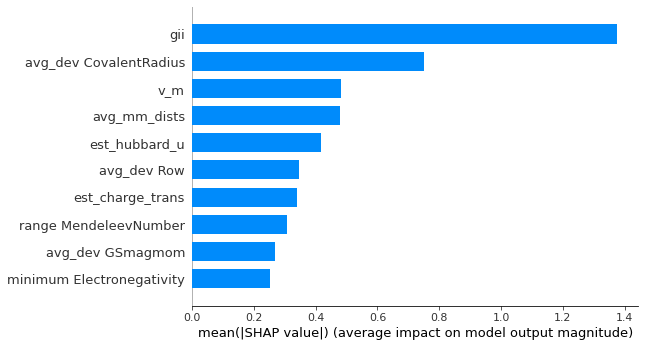

In [13]:
x_mit, _ = load_data(df, "MIT")
explainer = shap.TreeExplainer(mit_model)
shap_values = explainer.shap_values(x_mit)
shap.summary_plot(shap_values, x_mit, plot_type="bar", max_display=10)

Then, we can plot all the datapoints (training set + the new structure) on a 2D scatter plot of `range MendeleevNumber` vs. `avg_dev CovalentRadius`.

In [14]:
x_plot = "range MendeleevNumber"
y_plot = "avg_dev CovalentRadius"

In [15]:
# get the relevant columns from the training set
df_plot = df[["Compound", "Label", x_plot, y_plot]]
# get the relevant columns from the new structure dataframe
new_struct_plot = new_struct_df_with_name[["Compound", x_plot, y_plot]]
# assign 3 to new strucuture's label to distinguish it from the original training set
new_struct_plot["Label"] = "new_struct"
# combine the two datasets
combined_df_plot = pd.concat([df_plot, new_struct_plot], ignore_index=True)
# change the numeric label into string format to allow discrete color scale for plotting
combined_df_plot = combined_df_plot.replace({"Label": {0: "metal", 1: "insulator", 2: "mit"}})
combined_df_plot

,Compound,Label,range MendeleevNumber,avg_dev CovalentRadius
0,BaMoO3,metal,78.0,56.880000
1,BaOsO3,metal,78.0,54.480000
2,Bi2Ru2O7,metal,31.0,37.487603
3,Ca3Ru2O7,metal,80.0,47.638889
4,CaCrO3,metal,80.0,43.920000
...,...,...,...,...
220,VO,mit,41.0,43.500000
221,VO2,mit,41.0,38.666667
222,YNiO3,mit,75.0,43.680000
223,YbFe4(CuO4)3,mit,48.0,34.980000


Create a scatter plot.

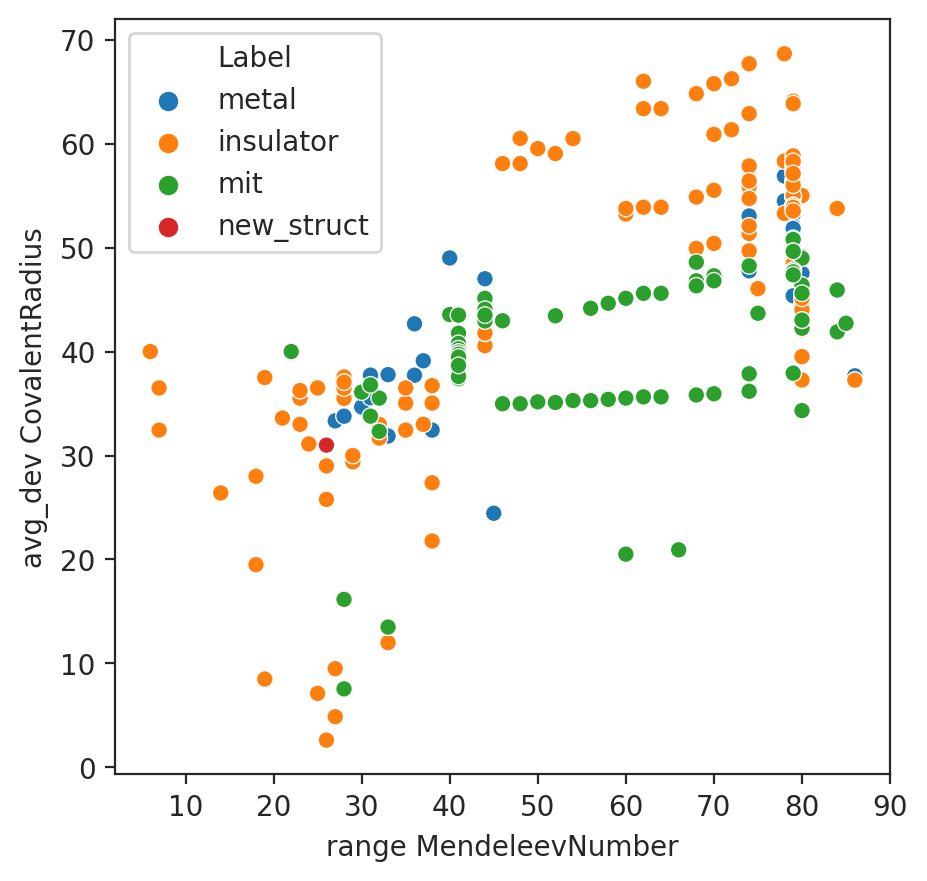

In [16]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(5,5), dpi=200)
    sns.scatterplot(data=combined_df_plot, x=x_plot, y=y_plot, hue="Label")